<a href="https://colab.research.google.com/github/orkohol/-/blob/main/vgg16_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification with Keras and TensorFlow using VGG-16

This project demonstrates the implementation of an image classification model using Keras and TensorFlow, leveraging the pre-trained VGG-16 architecture. The objective is to classify images into two categories: "O" and "R." The project utilizes transfer learning to fine-tune the VGG-16 model on a reduced dataset, achieving promising results.

### Installing Required Libraries

Before proceeding, ensure the following libraries are installed:

In [ ]:
!pip install tensorflow
!pip install numpy
!pip install scikit-learn
!pip install matplotlib

### Importing Required Libraries

Import the necessary libraries for data processing, model building, and evaluation:

In [1]:
import numpy as np
import os
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread

# from os import makedirs,listdir
# from shutil import copyfile
# from random import seed
# from random import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications import InceptionV3
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')


### Data Importation

The dataset used in this project is downloaded and extracted:

In [2]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist()
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:00<00:00, 1381.01file/s]

Finished extracting file
Finished extracting file


### Configuration Options

Define configuration parameters for image dimensions, batch size, epochs, and other settings:

In [3]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### ImageDataGenerators for Training, Validation, and Testing

To efficiently process and augment image data, I utilized `ImageDataGenerator` for training, validation, and testing.  

- **Data Augmentation:**  
  I applied augmentation only to the training data to prevent data leakage. This ensures that the model learns to generalize from varied inputs without being exposed to transformed validation or test images. Augmentation techniques applied include rotations, flips, and zooms to improve the model's robustness.  

- **Binary Classification:**  
  Since the problem involves two classes, I set the `class_mode` parameter to `'binary'`. This configuration is appropriate for binary classification tasks and allows the model to predict probabilities for the two classes.  


In [4]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)
test_generator = test_datagen.flow_from_directory(
    directory=path_test,
    class_mode='binary',
    seed=seed,
    batch_size=batch_size,
    shuffle=False,
    target_size=(img_rows, img_cols)
)

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## VGG-16 Model Implementation

This section focuses on utilizing the pre-trained VGG-16 model for image classification.

The process involves:

1. Loading the VGG-16 model with pre-trained weights from ImageNet.
2. Removing the final classification layer to adapt it for our specific task.
3. Flattening the output of the convolutional layers for input to a fully connected layer.
4. Freezing the weights of the VGG-16 layers to prevent them from being updated during initial training. This helps preserve the pre-trained features.

In [5]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### Adding Classification Layers

After leveraging the pre-trained VGG-16 base, we introduce new, trainable layers to tailor the model for our specific binary classification task ("O" vs. "R").

In [6]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

### Model Compilation

I chose the following parameters for model compilation based on the nature of the problem and the desired performance:

- **Loss Function - Binary Cross-Entropy:**  
  Since the problem involves binary classification (two classes), binary cross-entropy is the most suitable loss function. It effectively measures the difference between the predicted probabilities and the actual class labels, guiding the model to optimize for accurate classification.

- **Optimizer - RMSprop:**  
  I selected the RMSprop optimizer with a small learning rate, as it is well-suited for fine-tuning neural networks. RMSprop adapts the learning rate individually for each parameter, allowing for more stable and efficient convergence.

- **Metric - Accuracy:**  
  Accuracy is an intuitive and direct metric for evaluating the model's performance in binary classification tasks. It provides a clear indication of how often the model correctly predicts the target class.


In [7]:
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

### Callbacks and Early Stopping

To optimize computational resources and prevent overfitting, I implemented several callbacks during model training.

- **LearningRateScheduler:**  
  I utilized a logarithmic scaling approach to gradually decrease the learning rate as the training progresses. This approach helps the model converge more efficiently while reducing the risk of overshooting the optimal solution.

- **EarlyStopping:**  
  To prevent unnecessary training, I configured EarlyStopping to monitor the validation loss. If no improvement greater than 0.01 is observed over 4 consecutive epochs, the training process is halted. This strategy helps maintain model generalization and reduces training time.

- **Training Progress Monitoring:**  
  I included print statements to display the training loss and current learning rate, allowing for real-time performance tracking.

- **ModelCheckpoint:**  
  To ensure that the best model parameters are preserved, I used the ModelCheckpoint callback. This saves the model's state whenever an improvement is detected, safeguarding the most optimal version during training.


In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

### Model Training and Evaluation  

To train the model efficiently, I used the standard `fit` function.  

- **Steps Per Epoch - 5:**  
  I chose `steps_per_epoch=5` to reduce computational load while still allowing the model to update weights adequately within each epoch. This choice balances training efficiency with model performance.  

- **Training and Validation Curves:**  
  After training, I utilized `matplotlib` to visualize the loss and accuracy curves. Plotting these metrics helps evaluate model convergence and detect potential overfitting or underfitting.  


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5534 - loss: 0.6788lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 673ms/step - accuracy: 0.5591 - loss: 0.6734 - val_accuracy: 0.6146 - val_loss: 0.6217 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6981 - loss: 0.5270lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.6974 - loss: 0.5306 - val_accuracy: 0.6771 - val_loss: 0.5638 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7203 - loss: 0.5225lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - accuracy: 0.7201 - loss: 0.5233 - val_accuracy: 0.7865 - val_loss: 0.4679 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7809 - loss: 0.4663lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.7820 - loss: 0.4639 - val_accuracy: 0.6823 - val_loss: 0.5255 - learning_rate: 7.40

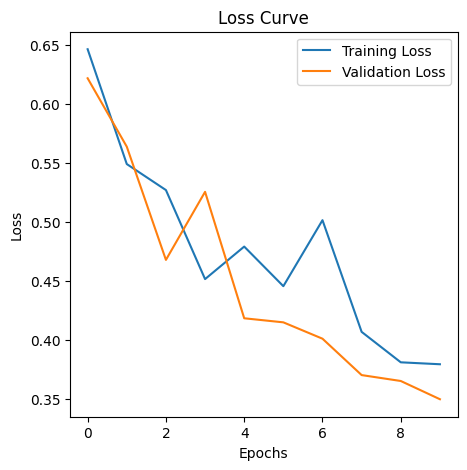

[]

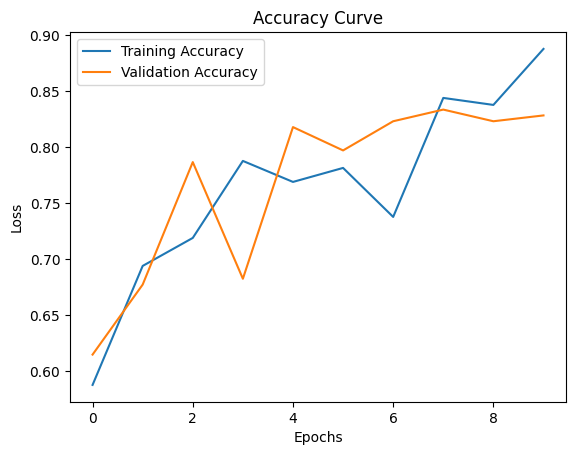

In [9]:
extract_feat_model = model.fit(train_generator,
                               steps_per_epoch=5,
                               epochs=10,
                               callbacks = callbacks_list_,
                               validation_data=val_generator,
                               validation_steps=val_generator.samples // batch_size,
                               verbose=1)

import matplotlib.pyplot as plt

history = extract_feat_model

# plot loss curve
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

history = extract_feat_model
figsize=(5, 5)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.plot()

### Fine-Tuning the VGG16 Model  

After establishing a baseline with initial training, we proceed to fine-tune the model to further improve performance.  

- **Unfreezing Layers:**  
  To enhance feature learning, we unfreeze the last 4 layers of the VGG16 model. This allows the model to adapt high-level features more effectively, leveraging the pre-trained knowledge while refining it for the specific task.  

- **Setting a New Checkpoint:**  
  To capture the improvements, a new `ModelCheckpoint` is set to save the updated model weights whenever performance increases.  

- **Model Compilation and Training:**  
  After unfreezing the layers, the model is recompiled to incorporate the changes, and training is resumed. We will then evaluate the results to assess the impact of fine-tuning on model performance.  


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7480 - loss: 0.7238lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 658ms/step - accuracy: 0.7411 - loss: 0.7241 - val_accuracy: 0.9323 - val_loss: 0.2630 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9303 - loss: 0.2298lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - accuracy: 0.9294 - loss: 0.2288 - val_accuracy: 0.9010 - val_loss: 0.2197 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9629 - loss: 0.1765lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 600ms/step - accuracy: 0.9608 - loss: 0.1814 - val_accuracy: 0.9219 - val_loss: 0.1928 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.8246 - loss: 0.3039lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 418ms/step - accuracy: 0.8309 - loss: 0.3003 - val_accuracy: 0.9115 - val_loss: 0.1886 - learning_rate: 7.4

[]

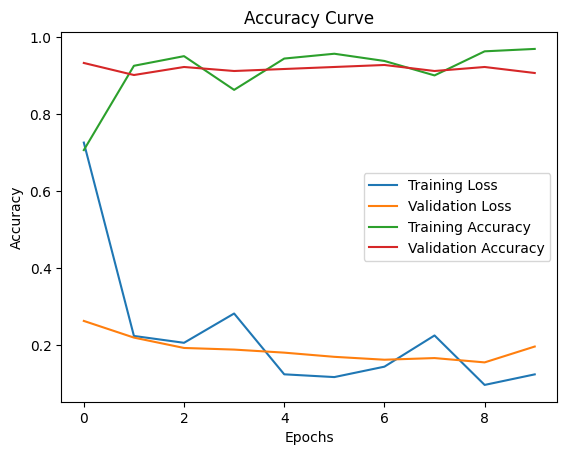

In [12]:
for layer in basemodel.layers[-4:]:
    layer.trainable = True

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss',
                    patience = 4,
                    mode = 'min',
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator,
                    steps_per_epoch=5,
                    epochs=10,
                    callbacks = callbacks_list_,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // batch_size,
                    verbose=1)

history = fine_tune_model

figsize=(5, 5)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.plot()

history = fine_tune_model

figsize=(5, 5)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.plot()

### Model Evaluation

The performance of both the initial and fine-tuned models is evaluated using a classification report:

In [13]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))


Extract Features Model
              precision    recall  f1-score   support

           O       0.85      0.94      0.90        50
           R       0.93      0.84      0.88        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.90      0.90      0.90        50
           R       0.90      0.90      0.90        50

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100



### Model Evaluation with Visualizations

Visualizations are used to further analyze model performance on individual images:

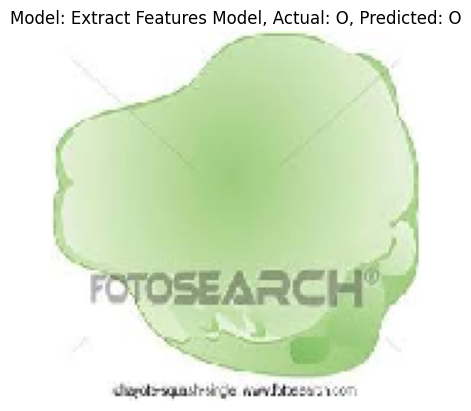

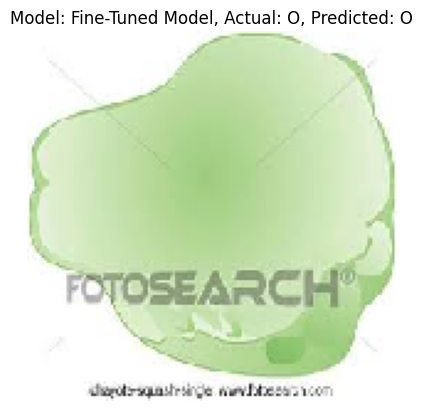

In [15]:
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

import random

index_to_plot = random.randint(0, len(test_imgs) - 1)  # Generate random index

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot]
)

plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot],
    predicted_label=predictions_extract_feat_model[index_to_plot]
)

### Conclusion

This project demonstrates the successful implementation of an image classification model using transfer learning with VGG-16. The fine-tuned model achieved slightly higher accuracy in classifying images. Further improvements could be explored by experimenting with different hyperparameters or exploring other pre-trained models.